In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets

# Loading Data

In [183]:
iris = datasets.load_iris()
wine = datasets.load_wine()
breast_cancer =datasets.load_breast_cancer()

In [184]:
iris_data = iris.data
iris_labels = iris.target
wine_data = wine.data
wine_labels = wine.target
breast_cancer_data = breast_cancer.data
breast_cancer_labels = breast_cancer.target

# Dataframe adjusting

In [106]:
np.random.seed(1)
indices = np.random.permutation(len(iris_data))
n_training_samples = 30
train_set_data = iris_data[indices[:-n_training_samples]]
train_set_labels = iris_labels[indices[:-n_training_samples]]
test_set_data = iris_data[indices[-n_training_samples:]]
test_set_labels = iris_labels[indices[-n_training_samples:]]
print(train_set_data[:4], train_set_labels[:4])
print(test_set_data[:4], test_set_labels[:4])

[[5.8 4.  1.2 0.2]
 [5.1 2.5 3.  1.1]
 [6.6 3.  4.4 1.4]
 [5.4 3.9 1.3 0.4]] [0 1 1 0]
[[4.6 3.2 1.4 0.2]
 [6.4 3.2 5.3 2.3]
 [4.3 3.  1.1 0.1]
 [5.6 3.  4.1 1.3]] [0 2 0 1]


In [136]:
def split_data(percent,data, target):
    """Function splits data according to percent
    

# Data Visualization

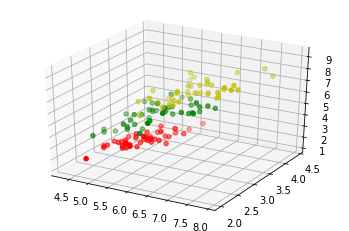

In [21]:
%matplotlib inline 
.from mpl_toolkits.mplot3d import Axes3D

colours = ("r", "b")
X = []
for iclass in range(3):
    X.append([[], [], []])
    for i in range(len(train_set_data)):
        if train_set_labels[i] == iclass:
            X[iclass][0].append(train_set_data[i][0])
            X[iclass][1].append(train_set_data[i][1])
            X[iclass][2].append(sum(train_set_data[i][2:]))

colours = ("r", "g", "y")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for iclass in range(3):
       ax.scatter(X[iclass][0], X[iclass][1], X[iclass][2], c=colours[iclass])
plt.show()

# Determining the distance between points

In [43]:
def distance(first, second):
    """Calculate Euclidian distance between two point in n-dim space"""
    x1 = np.array(first.copy())
    x2 = np.array(second.copy())
    return np.sqrt(sum([pow(x-y,2) for x, y in zip(x1, x2)]))

In [49]:
print(distance([3,5], [1,1]))
print(distance(train_set_data[3], train_set_data[44]))

4.47213595499958
3.4190641994557516


# Determining the neighbors

In [51]:
def get_neighbors(train_set, labels, test_instance, k, distance=distance):
    """function calculates list of K nearest neighbors for test_instance"""
    distances = []
    for index in range(len(train_set)):
        dist = distance(test_instance, train_set[index])
        distances.append((train_set[index], dist, labels[index]))
    
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors

In [84]:
for i in range(5):
    neighbors = get_neighbors(train_set_data, train_set_labels,  test_set_data[i], 3, 
                              distance=distance)
    print(i,  test_set_data[i], test_set_labels[i], neighbors)

0 [5.7 2.8 4.1 1.3] 1 [(array([5.7, 2.9, 4.2, 1.3]), 0.14142135623730995, 1), (array([5.6, 2.7, 4.2, 1.3]), 0.17320508075688815, 1), (array([5.6, 3. , 4.1, 1.3]), 0.22360679774997935, 1)]
1 [6.5 3.  5.5 1.8] 2 [(array([6.4, 3.1, 5.5, 1.8]), 0.1414213562373093, 2), (array([6.3, 2.9, 5.6, 1.8]), 0.24494897427831783, 2), (array([6.5, 3. , 5.2, 2. ]), 0.3605551275463988, 2)]
2 [6.3 2.3 4.4 1.3] 1 [(array([6.2, 2.2, 4.5, 1.5]), 0.26457513110645864, 1), (array([6.3, 2.5, 4.9, 1.5]), 0.574456264653803, 1), (array([6. , 2.2, 4. , 1. ]), 0.5916079783099617, 1)]
3 [6.4 2.9 4.3 1.3] 1 [(array([6.2, 2.9, 4.3, 1.3]), 0.20000000000000018, 1), (array([6.6, 3. , 4.4, 1.4]), 0.2645751311064587, 1), (array([6.6, 2.9, 4.6, 1.3]), 0.3605551275463984, 1)]
4 [5.6 2.8 4.9 2. ] 2 [(array([5.8, 2.7, 5.1, 1.9]), 0.31622776601683755, 2), (array([5.8, 2.7, 5.1, 1.9]), 0.31622776601683755, 2), (array([5.7, 2.5, 5. , 2. ]), 0.33166247903553986, 2)]


# Voting for most common instance

In [53]:
from collections import Counter

In [189]:
def vote(neighbors):
    """Function calculates the most common instance"""
    class_counter = Counter()
    for nb in neighbors:
        class_counter[nb[2]] += 1
    return class_counter.most_common(1)[0][0]

def vote_distance_weights(neighbors, all_results=True):
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
        dist = neighbors[index][1]
        label = neighbors[index][2]
        class_counter[label] += 1 / (dist**2 + 1)
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if all_results:
        total = sum(class_counter.values(), 0.0)
        for key in class_counter:
             class_counter[key] /= total
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [191]:
for i in range(n_training_samples):
    neighbors = get_neighbors(train_set_data, 
                              train_set_labels, 
                              test_set_data[i], 
                              3, 
                              distance=distance)
    print("index: ", i, 
          ",vote: ", vote(neighbors),
          ",weighted vote: ", vote_distance_weights(neighbors)[0],
          ", label: ", test_set_labels[i], 
          ", data: ", test_set_data[i])

index:  0 ,vote:  0 ,weighted vote:  0 , label:  0 , data:  [4.6 3.2 1.4 0.2]
index:  1 ,vote:  2 ,weighted vote:  2 , label:  2 , data:  [6.4 3.2 5.3 2.3]
index:  2 ,vote:  0 ,weighted vote:  0 , label:  0 , data:  [4.3 3.  1.1 0.1]
index:  3 ,vote:  1 ,weighted vote:  1 , label:  1 , data:  [5.6 3.  4.1 1.3]
index:  4 ,vote:  0 ,weighted vote:  0 , label:  0 , data:  [4.4 2.9 1.4 0.2]
index:  5 ,vote:  1 ,weighted vote:  1 , label:  1 , data:  [5.5 2.4 3.7 1. ]
index:  6 ,vote:  1 ,weighted vote:  1 , label:  1 , data:  [5.  2.  3.5 1. ]
index:  7 ,vote:  0 ,weighted vote:  0 , label:  0 , data:  [5.1 3.5 1.4 0.2]
index:  8 ,vote:  0 ,weighted vote:  0 , label:  0 , data:  [4.9 3.  1.4 0.2]
index:  9 ,vote:  1 ,weighted vote:  1 , label:  1 , data:  [4.9 2.4 3.3 1. ]
index:  10 ,vote:  0 ,weighted vote:  0 , label:  0 , data:  [4.6 3.6 1.  0.2]
index:  11 ,vote:  1 ,weighted vote:  1 , label:  1 , data:  [5.9 3.  4.2 1.5]
index:  12 ,vote:  1 ,weighted vote:  1 , label:  1 , data:  [

In [192]:
def make_prediction(train_set_d, train_set_l, test_set_d, test_set_l, k):
    """Function makes prediction for the testset data"""
    actual_test_set_l = test_set_l.copy()
    result_test_set_l = []
    for instance in test_set_d:
        neighbors = get_neighbors(train_set_d, train_set_l, instance, k)
        result_test_set_l.append(vote(neighbors))
    return np.array([actual_test_set_l,result_test_set_l])

def make_prediction_weighted(train_set_d, train_set_l, test_set_d, test_set_l, k):
    """Function makes prediction for the testset data"""
    actual_test_set_l = test_set_l.copy()
    result_test_set_l = []
    for instance in test_set_d:
        neighbors = get_neighbors(train_set_d, train_set_l, instance, k)
        result_test_set_l.append(vote_distance_weights(neighbors)[0])
    return np.array([actual_test_set_l,result_test_set_l])



In [107]:
pred_test = make_prediction(train_set_data,train_set_labels, test_set_data, test_set_labels,3)

In [112]:
def test_accuracy(actual, predicted):
    """Function tests accuracy of prediction"""
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [108]:
test_accuracy(pred_test[0], pred_test[1])

96.66666666666667

# Creating plots for not weighted KNN for Iris

In [138]:
len(split_data(33,iris_data, iris_labels)[2])

49

    K value  Test Set Size  Accuracy
0       1.0           10.0      86.7
1       1.0           20.0      93.3
2       1.0           30.0      91.1
3       1.0           40.0      91.7
4       1.0           50.0      93.3
5       1.0           60.0      93.3
6       1.0           70.0      91.4
7       1.0           80.0      90.8
8       1.0           90.0      88.9
9       3.0           10.0      93.3
10      3.0           20.0      96.7
11      3.0           30.0      93.3
12      3.0           40.0      95.0
13      3.0           50.0      94.7
14      3.0           60.0      94.4
15      3.0           70.0      91.4
16      3.0           80.0      87.5
17      3.0           90.0      88.9
18      5.0           10.0      93.3
19      5.0           20.0      96.7
20      5.0           30.0      93.3
21      5.0           40.0      93.3
22      5.0           50.0      93.3
23      5.0           60.0      91.1
24      5.0           70.0      93.3
25      5.0           80.0      88.3
2

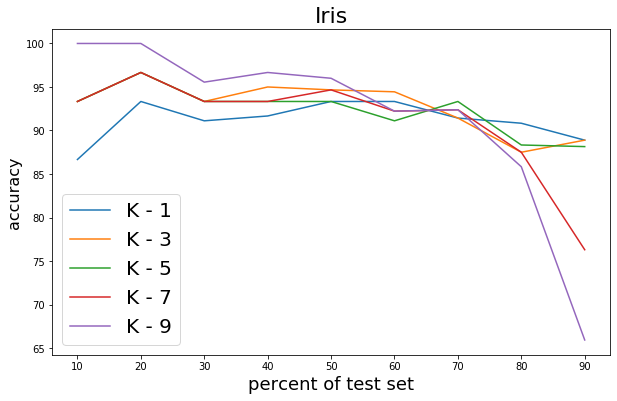

In [212]:
k_value = [1, 3, 5, 7, 9]
dependency_array=[]
plt.figure(figsize=(10,6))
plt.title("Iris", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,iris_data, iris_labels)
        pred_test = make_prediction(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower left",prop={'size': 20})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df1 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df1)
plt.show()

# Creating plots for weighted KNN for Iris

    K value  Test Set Size  Accuracy
0       1.0           10.0      86.7
1       1.0           20.0      93.3
2       1.0           30.0      91.1
3       1.0           40.0      91.7
4       1.0           50.0      93.3
5       1.0           60.0      93.3
6       1.0           70.0      91.4
7       1.0           80.0      90.8
8       1.0           90.0      88.9
9       3.0           10.0      93.3
10      3.0           20.0      96.7
11      3.0           30.0      93.3
12      3.0           40.0      95.0
13      3.0           50.0      94.7
14      3.0           60.0      94.4
15      3.0           70.0      91.4
16      3.0           80.0      87.5
17      3.0           90.0      88.9
18      5.0           10.0      93.3
19      5.0           20.0      96.7
20      5.0           30.0      93.3
21      5.0           40.0      93.3
22      5.0           50.0      93.3
23      5.0           60.0      91.1
24      5.0           70.0      93.3
25      5.0           80.0      88.3
2

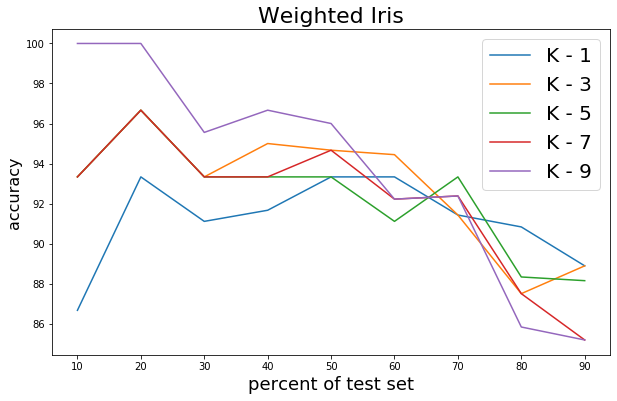

In [213]:
k_value = [1, 3, 5, 7, 9]
dependency_array=[]
plt.figure(figsize=(10,6))
plt.title("Weighted Iris", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,iris_data, iris_labels)
        pred_test = make_prediction_weighted(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="upper right",prop={'size': 20})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df2 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df2)
plt.show()

# Tests with normilized data Iris not Weighted KNN

    K value  Test Set Size  Accuracy
0       1.0           10.0      86.7
1       1.0           20.0      93.3
2       1.0           30.0      91.1
3       1.0           40.0      90.0
4       1.0           50.0      90.7
5       1.0           60.0      93.3
6       1.0           70.0      94.3
7       1.0           80.0      88.3
8       1.0           90.0      86.7
9       3.0           10.0      80.0
10      3.0           20.0      90.0
11      3.0           30.0      88.9
12      3.0           40.0      91.7
13      3.0           50.0      92.0
14      3.0           60.0      94.4
15      3.0           70.0      92.4
16      3.0           80.0      85.0
17      3.0           90.0      87.4
18      5.0           10.0      86.7
19      5.0           20.0      96.7
20      5.0           30.0      93.3
21      5.0           40.0      93.3
22      5.0           50.0      94.7
23      5.0           60.0      91.1
24      5.0           70.0      93.3
25      5.0           80.0      85.8
2

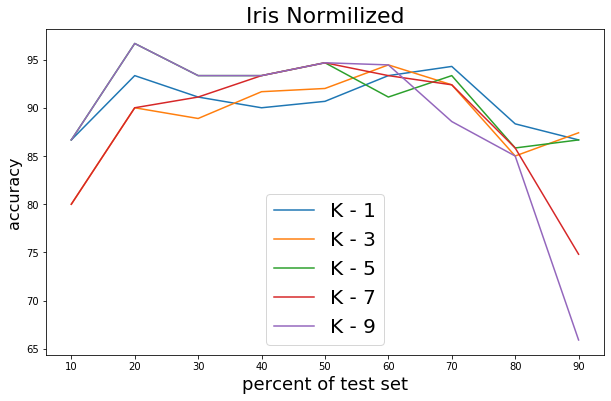

In [215]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
norm_iris_data = min_max_scaler.fit_transform(iris_data.copy())
k_value = [1, 3, 5, 7, 9]
dependency_array=[]
plt.figure(figsize=(10,6))
plt.title("Iris Normilized", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,norm_iris_data, iris_labels)
        pred_test = make_prediction(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower center",prop={'size': 20})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df3 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df3)
plt.show()

# Normilized Iris and Weighted KNN

    K value  Test Set Size  Accuracy
0       1.0           10.0      86.7
1       1.0           20.0      93.3
2       1.0           30.0      91.1
3       1.0           40.0      90.0
4       1.0           50.0      90.7
5       1.0           60.0      93.3
6       1.0           70.0      94.3
7       1.0           80.0      88.3
8       1.0           90.0      86.7
9       3.0           10.0      80.0
10      3.0           20.0      90.0
11      3.0           30.0      88.9
12      3.0           40.0      91.7
13      3.0           50.0      92.0
14      3.0           60.0      94.4
15      3.0           70.0      92.4
16      3.0           80.0      85.0
17      3.0           90.0      87.4
18      5.0           10.0      86.7
19      5.0           20.0      96.7
20      5.0           30.0      93.3
21      5.0           40.0      93.3
22      5.0           50.0      94.7
23      5.0           60.0      91.1
24      5.0           70.0      93.3
25      5.0           80.0      85.8
2

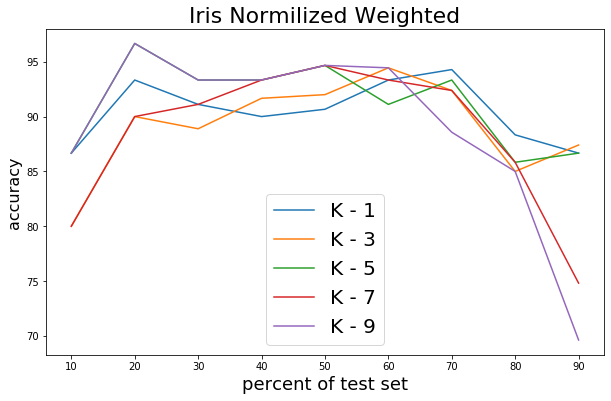

In [216]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
norm_iris_data = min_max_scaler.fit_transform(iris_data.copy())
k_value = [1, 3, 5, 7, 9]
dependency_array = []
plt.figure(figsize=(10,6))
plt.title("Iris Normilized Weighted", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,norm_iris_data, iris_labels)
        pred_test = make_prediction_weighted(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower center",prop={'size': 20})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df4 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df4)
plt.show()

# Creating plots for not weighted KNN for Wine

    K value  Test Set Size  Accuracy
0       1.0           10.0      52.9
1       1.0           20.0      62.9
2       1.0           30.0      67.9
3       1.0           40.0      66.2
4       1.0           50.0      73.0
5       1.0           60.0      66.0
6       1.0           70.0      66.1
7       1.0           80.0      66.2
8       1.0           90.0      66.9
9       3.0           10.0      70.6
10      3.0           20.0      74.3
11      3.0           30.0      79.2
12      3.0           40.0      73.2
13      3.0           50.0      74.2
14      3.0           60.0      67.9
15      3.0           70.0      67.7
16      3.0           80.0      70.4
17      3.0           90.0      70.0
18      5.0           10.0      58.8
19      5.0           20.0      68.6
20      5.0           30.0      73.6
21      5.0           40.0      73.2
22      5.0           50.0      70.8
23      5.0           60.0      68.9
24      5.0           70.0      69.4
25      5.0           80.0      71.1
2

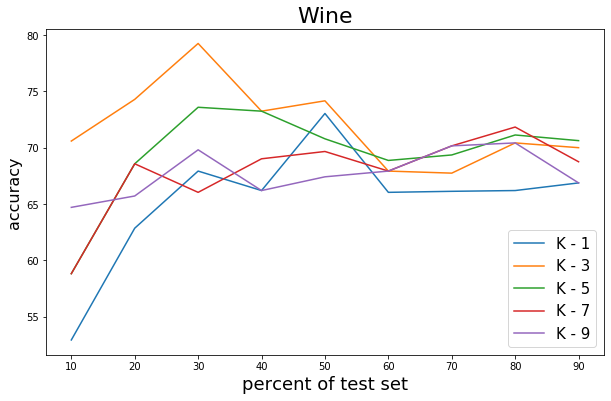

In [217]:
k_value = [1, 3, 5, 7, 9]
dependency_array = []
plt.figure(figsize=(10,6))
plt.title("Wine", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,wine_data, wine_labels)
        pred_test = make_prediction(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower right",prop={'size': 15})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df5 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df5)
plt.show()

# Weighted KNN for Wine

    K value  Test Set Size  Accuracy
0       1.0           10.0      52.9
1       1.0           20.0      62.9
2       1.0           30.0      67.9
3       1.0           40.0      66.2
4       1.0           50.0      73.0
5       1.0           60.0      66.0
6       1.0           70.0      66.1
7       1.0           80.0      66.2
8       1.0           90.0      66.9
9       3.0           10.0      52.9
10      3.0           20.0      65.7
11      3.0           30.0      73.6
12      3.0           40.0      69.0
13      3.0           50.0      71.9
14      3.0           60.0      67.9
15      3.0           70.0      68.5
16      3.0           80.0      69.0
17      3.0           90.0      69.4
18      5.0           10.0      52.9
19      5.0           20.0      68.6
20      5.0           30.0      71.7
21      5.0           40.0      69.0
22      5.0           50.0      71.9
23      5.0           60.0      67.9
24      5.0           70.0      65.3
25      5.0           80.0      66.9
2

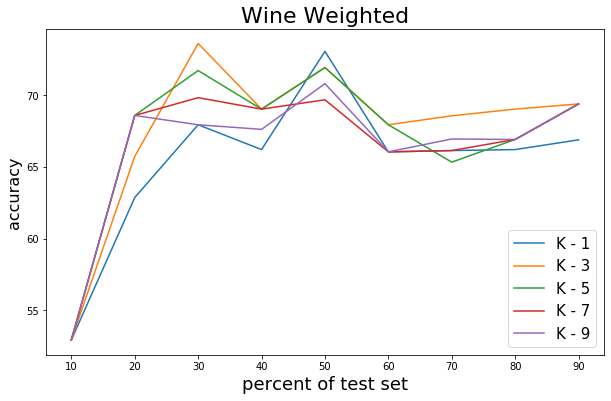

In [218]:
k_value = [1, 3, 5, 7, 9]
dependency_array = []
plt.figure(figsize=(10,6))
plt.title("Wine Weighted", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,wine_data, wine_labels)
        pred_test = make_prediction_weighted(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower right",prop={'size': 15})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df6 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df6)
plt.show()

# Normilized Wine

    K value  Test Set Size  Accuracy
0       1.0           10.0      94.1
1       1.0           20.0      91.4
2       1.0           30.0      92.5
3       1.0           40.0      94.4
4       1.0           50.0      93.3
5       1.0           60.0      92.5
6       1.0           70.0      92.7
7       1.0           80.0      93.7
8       1.0           90.0      91.2
9       3.0           10.0      94.1
10      3.0           20.0      94.3
11      3.0           30.0      96.2
12      3.0           40.0      95.8
13      3.0           50.0      96.6
14      3.0           60.0      94.3
15      3.0           70.0      95.2
16      3.0           80.0      93.7
17      3.0           90.0      94.4
18      5.0           10.0      88.2
19      5.0           20.0      97.1
20      5.0           30.0      98.1
21      5.0           40.0      97.2
22      5.0           50.0      95.5
23      5.0           60.0      95.3
24      5.0           70.0      94.4
25      5.0           80.0      94.4
2

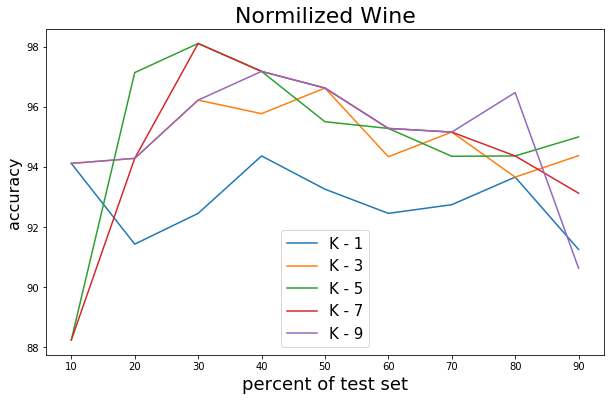

In [219]:
norm_wine_data = min_max_scaler.fit_transform(wine_data.copy())
k_value = [1, 3, 5, 7, 9]
dependency_array = []
plt.figure(figsize=(10,6))
plt.title("Normilized Wine", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,norm_wine_data, wine_labels)
        pred_test = make_prediction(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower center",prop={'size': 15})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df7 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df7)
plt.show()

# Weighted and Normilized Wine

    K value  Test Set Size  Accuracy
0       1.0           10.0      94.1
1       1.0           20.0      91.4
2       1.0           30.0      92.5
3       1.0           40.0      94.4
4       1.0           50.0      93.3
5       1.0           60.0      92.5
6       1.0           70.0      92.7
7       1.0           80.0      93.7
8       1.0           90.0      91.2
9       3.0           10.0      94.1
10      3.0           20.0      94.3
11      3.0           30.0      96.2
12      3.0           40.0      95.8
13      3.0           50.0      96.6
14      3.0           60.0      94.3
15      3.0           70.0      95.2
16      3.0           80.0      93.7
17      3.0           90.0      94.4
18      5.0           10.0      88.2
19      5.0           20.0      97.1
20      5.0           30.0      98.1
21      5.0           40.0      97.2
22      5.0           50.0      95.5
23      5.0           60.0      95.3
24      5.0           70.0      94.4
25      5.0           80.0      94.4
2

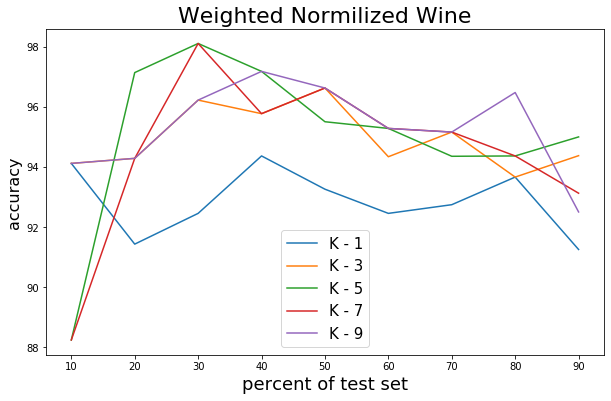

In [220]:
norm_wine_data = min_max_scaler.fit_transform(wine_data.copy())
k_value = [1, 3, 5, 7, 9]
dependency_array = []
plt.figure(figsize=(10,6))
plt.title("Weighted Normilized Wine", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,norm_wine_data, wine_labels)
        pred_test = make_prediction_weighted(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower center",prop={'size': 15})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df8 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df8)
plt.show()

# Creating plots for not weighted KNN for Breast Cancer


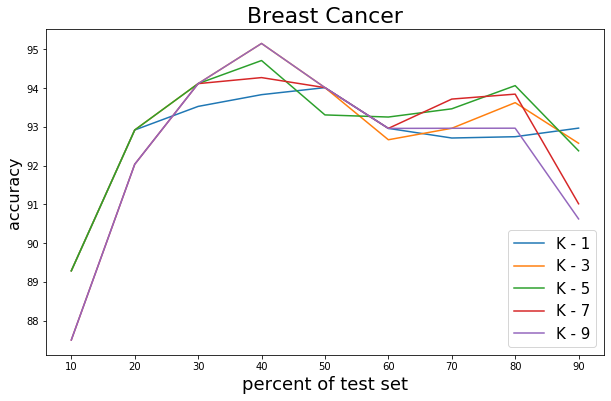

In [185]:
k_value = [1, 3, 5, 7, 9]
dependency_array = []
plt.figure(figsize=(10,6))
plt.title("Breast Cancer", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,breast_cancer_data, breast_cancer_labels)
        pred_test = make_prediction(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower right",prop={'size': 15})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df9 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df9)
plt.show()

# Tests with normilized data Breast Cancer

    K value  Test Set Size  Accuracy
0       1.0           10.0      96.4
1       1.0           20.0      97.3
2       1.0           30.0      97.6
3       1.0           40.0      97.4
4       1.0           50.0      96.5
5       1.0           60.0      95.9
6       1.0           70.0      94.7
7       1.0           80.0      95.6
8       1.0           90.0      94.5
9       3.0           10.0      98.2
10      3.0           20.0      98.2
11      3.0           30.0      98.2
12      3.0           40.0      97.4
13      3.0           50.0      96.8
14      3.0           60.0      96.2
15      3.0           70.0      96.2
16      3.0           80.0      96.5
17      3.0           90.0      95.5
18      5.0           10.0      98.2
19      5.0           20.0      97.3
20      5.0           30.0      98.8
21      5.0           40.0      97.4
22      5.0           50.0      97.9
23      5.0           60.0      97.1
24      5.0           70.0      97.0
25      5.0           80.0      95.8
2

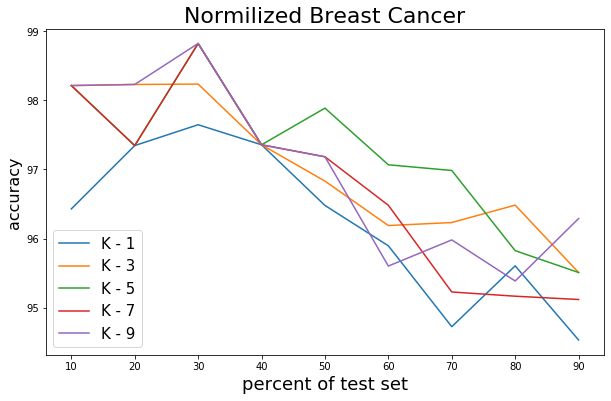

In [221]:
norm_breast_cancer_data = min_max_scaler.fit_transform(breast_cancer_data.copy())
k_value = [1, 3, 5, 7, 9]
dependency_array = []
plt.figure(figsize=(10,6))
plt.title("Normilized Breast Cancer", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,norm_breast_cancer_data, breast_cancer_labels)
        pred_test = make_prediction(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower left",prop={'size': 15})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df10 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df10)
plt.show()

# Weighted Breast Cancer

    K value  Test Set Size  Accuracy
0       1.0           10.0      89.3
1       1.0           20.0      92.9
2       1.0           30.0      93.5
3       1.0           40.0      93.8
4       1.0           50.0      94.0
5       1.0           60.0      93.0
6       1.0           70.0      92.7
7       1.0           80.0      92.7
8       1.0           90.0      93.0
9       3.0           10.0      89.3
10      3.0           20.0      92.9
11      3.0           30.0      94.1
12      3.0           40.0      94.7
13      3.0           50.0      93.7
14      3.0           60.0      92.1
15      3.0           70.0      92.7
16      3.0           80.0      93.4
17      3.0           90.0      93.2
18      5.0           10.0      89.3
19      5.0           20.0      92.9
20      5.0           30.0      94.1
21      5.0           40.0      94.7
22      5.0           50.0      93.3
23      5.0           60.0      93.0
24      5.0           70.0      93.0
25      5.0           80.0      93.6
2

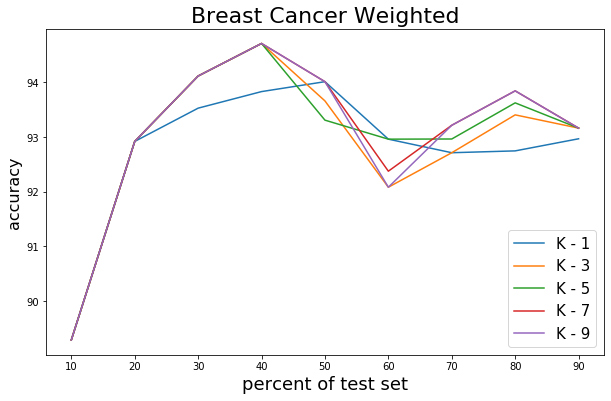

In [222]:
k_value = [1, 3, 5, 7, 9]
dependency_array = []
plt.figure(figsize=(10,6))
plt.title("Breast Cancer Weighted", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,breast_cancer_data, breast_cancer_labels)
        pred_test = make_prediction_weighted(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower right",prop={'size': 15})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df11 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df11)
plt.show()

# Weighted and Normilized Breast Cancer

NameError: name 'make_prediction_weightedweightedeightedeightedeighted' is not defined

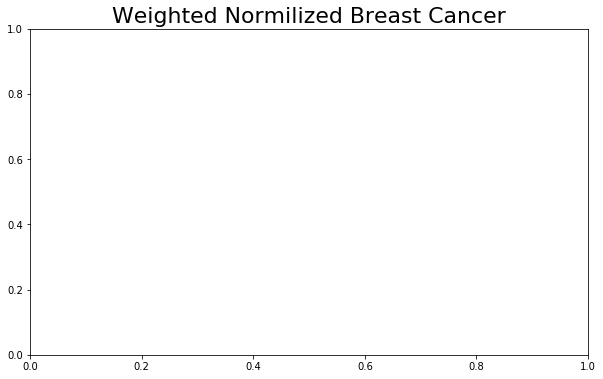

In [223]:
norm_breast_cancer_data = min_max_scaler.fit_transform(breast_cancer_data.copy())
k_value = [1, 3, 5, 7, 9]
dependency_array = []
plt.figure(figsize=(10,6))
plt.title("Weighted Normilized Breast Cancer", fontsize=22)
for k in k_value:
    percent_of_test = list(range(10, 100, 10))
    accuracy = []
    for per in percent_of_test:
        data = split_data(per,norm_breast_cancer_data, breast_cancer_labels)
        pred_test = make_prediction_weightedweightedeightedeightedeighted(data[0],data[1], data[2], data[3],k)
        acc = test_accuracy(pred_test[0], pred_test[1])
        accuracy.append(acc)
        dependency_array.append([k, per, round(acc,1)])
    plt.plot(percent_of_test, accuracy, label ="K - "+str(k))
    plt.legend(loc="lower left",prop={'size': 15})
    plt.xlabel('percent of test set', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
dat_ir_sim = np.array(dependency_array)
df12 = pd.DataFrame({'K value': dat_ir_sim[:, 0], 'Test Set Size': dat_ir_sim[:, 1], 'Accuracy': dat_ir_sim[:, 2]})
print(df12)
plt.show()